In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import sklearn.metrics
import tensorflow as tf

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5420,00029388_000.png,No Finding,0,29388,029Y,M,PA,2021,2021,0.194311,0.194311
520,00002704_005.png,No Finding,5,2704,039Y,F,AP,2048,2500,0.168000,0.168000
654,00003393_008.png,No Finding,8,3393,058Y,M,AP,2500,2048,0.171000,0.171000


In [3]:
## EDA
# Todo 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
104213,00027836_000.png,No Finding,0,27836,19,M,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50687,00012834_092.png,Effusion|Infiltration,92,12834,33,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
78661,00019297_001.png,No Finding,1,19297,29,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
all_xray_df['Pneumonia'].value_counts()

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

[Text(0, 0.5, 'Number of Images with Label')]

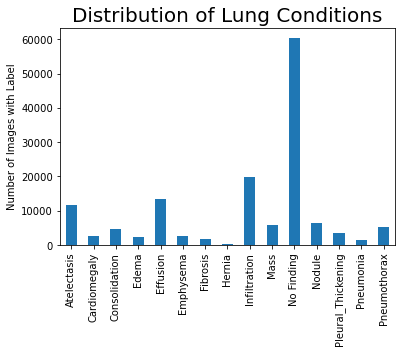

In [5]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
ax = all_xray_df[all_labels].sum().plot(kind='bar')
plt.title("Distribution of Lung Conditions", size = 20)
ax.set(ylabel = 'Number of Images with Label')

#### Observation: 
It can be seen that the majority of X-rays contain no sign of any pulmonary condition. The most common conditions include Infiltration, Effusion and Atelectasis. The least common conditions in the X-rays are Hernias, Pneumonia and Fibrosis.

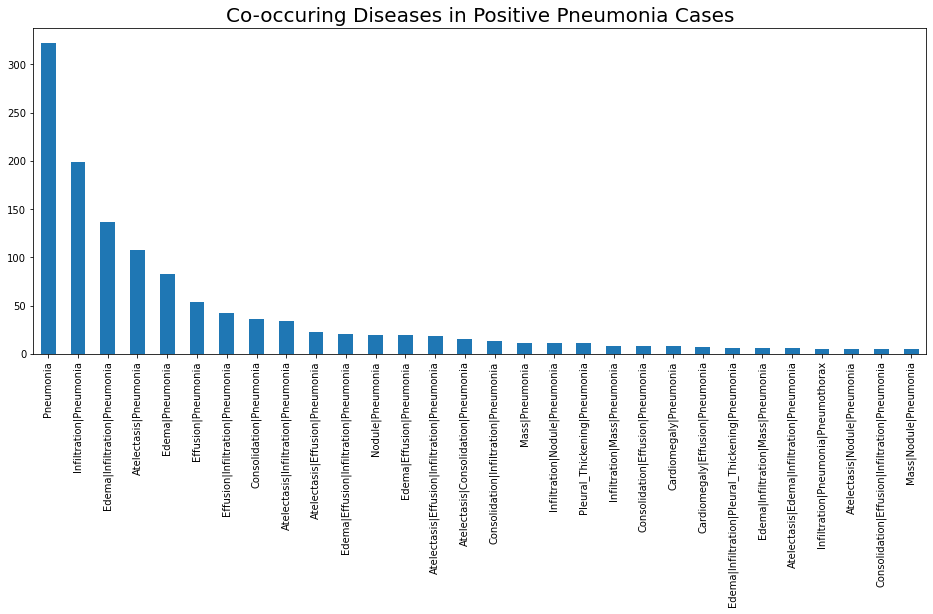

In [6]:
plt.figure(figsize=(16,6))
plt.title("Co-occuring Diseases in Positive Pneumonia Cases", size = 20)
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

#### Observation:
The most common co-ocurring conditions seen with Pneumonia are Infiltration, Edema and Infiltration, and Atelectasis. Fibrosis is the least common co-ocurring condition in Pneumonia.

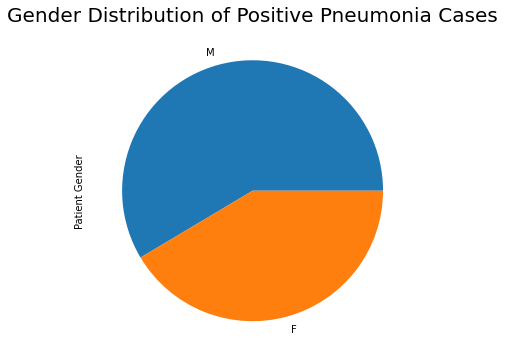

In [7]:
plt.figure(figsize=(6,6))
plt.title("Gender Distribution of Positive Pneumonia Cases", size = 20)
all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts().plot(kind='pie')

#### Observation:
There are more males than females within the NIH dataset. The data orginates in the United States of America. According to estimates, the American population contains a population that has an equal distribution of male to females. This dataset is biased towards males.  

In [8]:
print("The percentage of males is: {:.0f}%\nThe percentage of females is {:.0f}%".format(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts()[0]/len(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender']) * 100, 100 - all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts()[0]/len(all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender']) * 100))

The percentage of males is: 59%
The percentage of females is 41%


(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

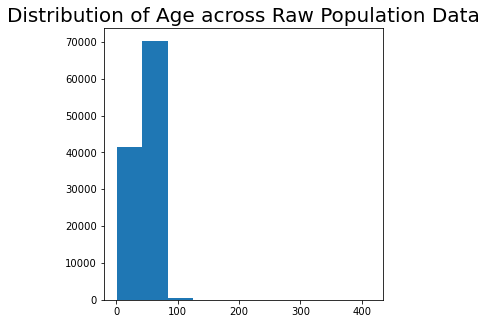

In [9]:
plt.figure(figsize=(5,5))
plt.title("Distribution of Age across Raw Population Data", size=20)
plt.hist(all_xray_df['Patient Age'])

#### Observation:
From the frequency distribution, it can be seen that there there presence of an outlier as the outlier is affecting the visualization.

In [10]:
print("Highest age in population data: {}".format(max(all_xray_df['Patient Age'])))

Highest age in population data: 414


In [11]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

In [12]:
all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] > 120].index, inplace=True) # Dropping outliers from dataset

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

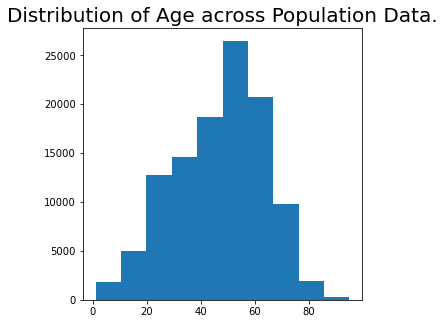

In [13]:
plt.figure(figsize=(5,5))
plt.title("Distribution of Age across Population Data.", size = 20)
plt.hist(all_xray_df['Patient Age'])

#### Observation:
After removing the outlier, a normal distribution can be found. The youngest age being 1 years old and the oldest 95 years. The majority of ages fall between the ages of 20 and 80 years of age. 

In [14]:
all_xray_df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

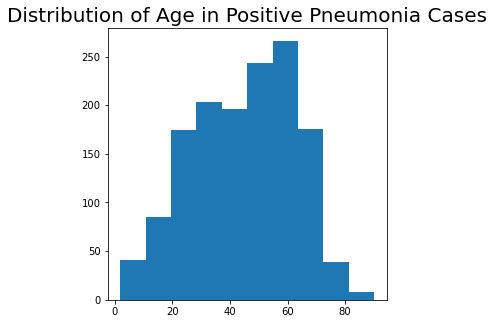

In [15]:
plt.figure(figsize=(5,5))
plt.title("Distribution of Age in Positive Pneumonia Cases", size = 20)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Pneumonia'] == 1])

#### Observation:
From the graph, it can be seen that the distribution is normal. The average age of the positive pneumonia cases is relatively younger at 46 years of age. 

In [16]:
all_xray_df['Patient Age'][all_xray_df['Pneumonia'] == 1].describe()

count    1430.000000
mean       44.670629
std        17.639098
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

(array([ 1762.,  4936., 12608., 14366., 18454., 26188., 20532.,  9678.,
         1895.,   255.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

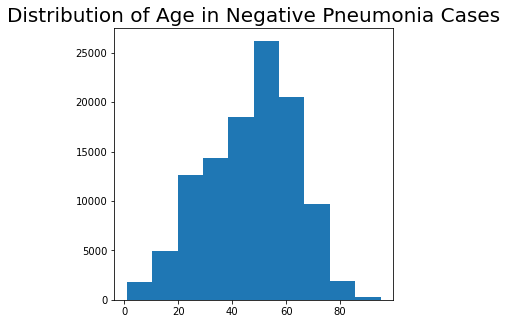

In [17]:
plt.figure(figsize=(5,5))
plt.title("Distribution of Age in Negative Pneumonia Cases", size = 20)
plt.hist(all_xray_df['Patient Age'][all_xray_df['Pneumonia'] == 0])

#### Observation:
From the graph, it can be seen that the distribution is normal. The average age of the negative pneumonia cases is relatively older at 49 years of age as compared to the population of positive pneumonia cases. 

In [18]:
all_xray_df['Patient Age'][all_xray_df['Pneumonia'] == 0].describe()

count    110674.000000
mean         46.901025
std          16.582446
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

In [19]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

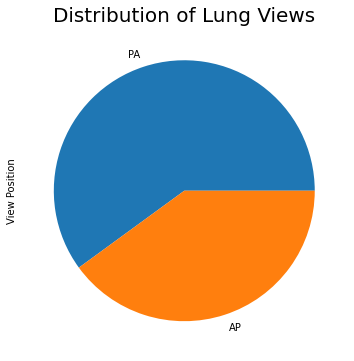

In [20]:
plt.figure(figsize=(6,6))
plt.title("Distribution of Lung Views", size = 20)
all_xray_df['View Position'].value_counts().plot(kind='pie')

#### Observation:
The most common view of the lungs is the Posterior-Anterior view. However, the most important aspect is that all views within the dataset are of the correct types when viewing X-ray views of the lungs. 

In [21]:
print("The percentage of Posterior-Anterior views is: {:.0f}%\nThe percentage of Anterior-Posterior views is {:.0f}%".format(all_xray_df['View Position'].value_counts()[0]/len(all_xray_df['View Position']) * 100, 100 - all_xray_df['View Position'].value_counts()[0]/len(all_xray_df['View Position']) * 100))

The percentage of Posterior-Anterior views is: 60%
The percentage of Anterior-Posterior views is 40%


# Exploratory Data Analysis of 2D Imaging 

In [22]:
import pydicom
dcm1 = pydicom.dcmread('test1.dcm')
dcm2 = pydicom.dcmread('test2.dcm')
dcm3 = pydicom.dcmread('test3.dcm')
dcm4 = pydicom.dcmread('test4.dcm')
dcm5 = pydicom.dcmread('test5.dcm')
dcm6 = pydicom.dcmread('test6.dcm')

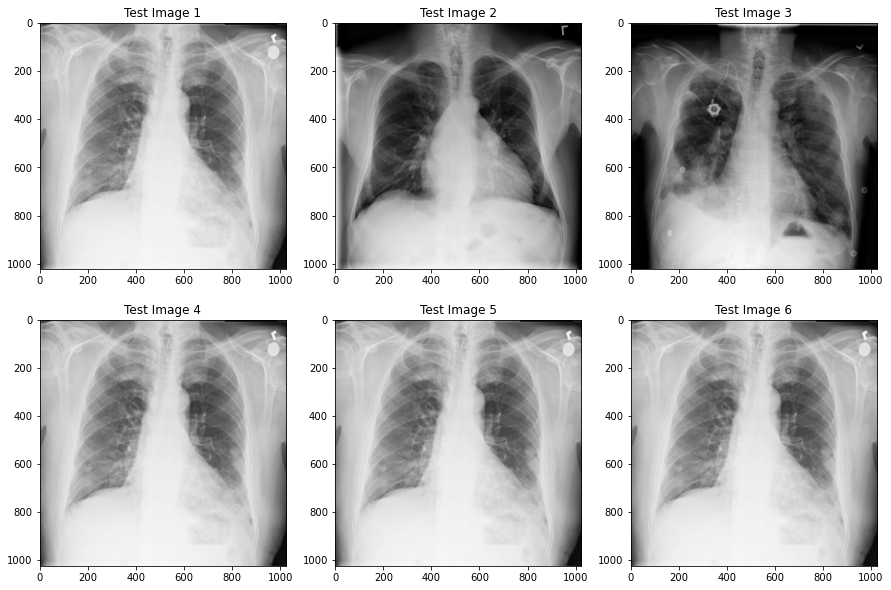

In [23]:
import matplotlib.pyplot as plt
import numpy as np
  
figure, axis = plt.subplots(2, 3, figsize=(15, 10))
  
axis[0, 0].imshow(dcm1.pixel_array,cmap='gray')
axis[0, 0].set_title("Test Image 1")

axis[0, 1].imshow(dcm2.pixel_array,cmap='gray')
axis[0, 1].set_title("Test Image 2")
  
axis[0, 2].imshow(dcm3.pixel_array,cmap='gray')
axis[0, 2].set_title("Test Image 3")
  
axis[1, 0].imshow(dcm4.pixel_array,cmap='gray')
axis[1, 0].set_title("Test Image 4")

axis[1, 1].imshow(dcm5.pixel_array,cmap='gray')
axis[1, 1].set_title("Test Image 5")
  
axis[1, 2].imshow(dcm6.pixel_array,cmap='gray')
axis[1, 2].set_title("Test Image 6")
  
plt.show()

#### Observations:
When viewing the test images, it can be seen that the second and third images are relatively darker. It's likely the intensities of the pixels will be less as compared to the other images. It also appears that the last three images are the exact same images. Further analysis is required.

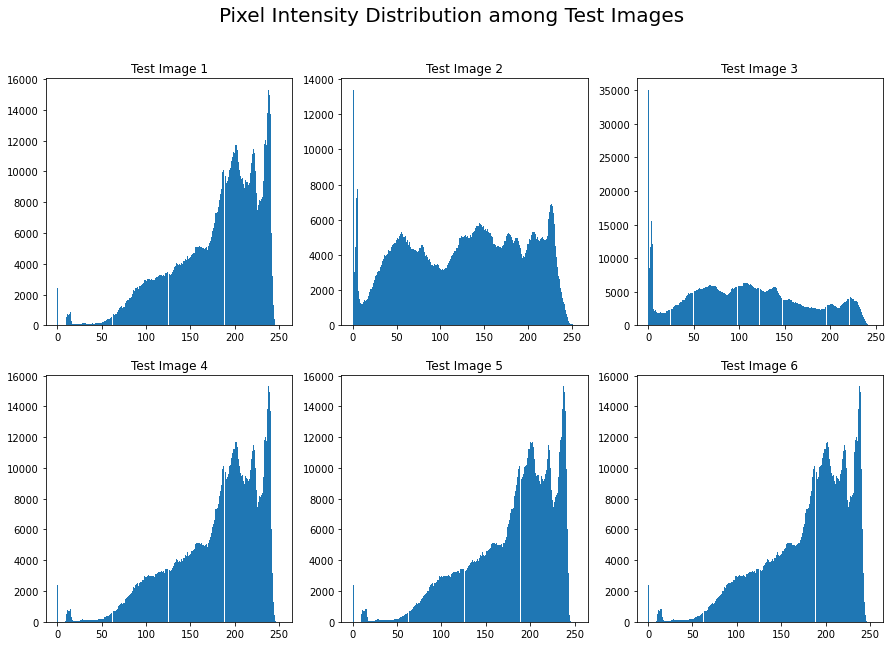

In [24]:
import matplotlib.pyplot as plt
import numpy as np
  

figure, axis = plt.subplots(2, 3, figsize=(15, 10))
  
axis[0, 0].hist(dcm1.pixel_array.ravel(), bins = 256)
axis[0, 0].set_title("Test Image 1")
  
axis[0, 1].hist(dcm2.pixel_array.ravel(), bins = 256)
axis[0, 1].set_title("Test Image 2")
  
axis[0, 2].hist(dcm3.pixel_array.ravel(), bins = 256)
axis[0, 2].set_title("Test Image 3")
  
axis[1, 0].hist(dcm4.pixel_array.ravel(), bins = 256)
axis[1, 0].set_title("Test Image 4")

axis[1, 1].hist(dcm5.pixel_array.ravel(), bins = 256)
axis[1, 1].set_title("Test Image 5")
  
axis[1, 2].hist(dcm6.pixel_array.ravel(), bins = 256)
axis[1, 2].set_title("Test Image 6")

figure.suptitle("Pixel Intensity Distribution among Test Images", size = 20)
plt.show()

#### Observations:
When viewing the test images, it can be seen that the second and third images have a different intensity distribution as compared to the other images. This is evident when viewing the original image. The last three images have the exact same image pixel intensity distributions. Overall, the pattern of distribution is the same among the similar images 1, 4, 5, 6. 